# Vision Transformer paper replicating

In this project we are going to replicate **machine learning research paper** and creating a **vision transformer (VIT)** from scratch using Python and PyTorch.

Link: https://arxiv.org/abs/2010.11929

## Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms as T

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4183, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 4183 (delta 64), reused 108 (delta 42), pack-reused 4035 (from 1)
Receiving objects: 100% (4183/4183), 652.89 MiB | 21.87 MiB/s, done.
Resolving deltas: 100% (2435/2435), done.
Updating files: 100% (248/248), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device = {device}")

Device = cuda


## Download Data

In [3]:
from helper_functions import download_data

image_path = download_data("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                           destination="pizza_steak_sushi")
print(f"Image path = {image_path}")

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...
Image path = data/pizza_steak_sushi


In [4]:
train_dir = image_path / "train"
test_dir = image_path / "test"

## Create Datasets and Dataloaders

In [5]:
from going_modular.going_modular.data_setup import create_dataloaders

BATCH_SIZE = 32 # Originally 4096
IMG_SIZE = 224 # Page 13

# Create transforms pipeline
data_transforms = T.Compose([
    T.Resize(size=(IMG_SIZE, IMG_SIZE)),
    T.ToTensor()
])
print(f"Manual transforms = {data_transforms}")

# Create train and test dataloaders
train_dataloader, test_dataloader, CLASS_NAMES = create_dataloaders(train_dir,
                                                                    test_dir,
                                                                    data_transforms,
                                                                    BATCH_SIZE)
len(train_dataloader), len(test_dataloader), CLASS_NAMES

Manual transforms = Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


(15, 5, ['pizza', 'steak', 'sushi'])

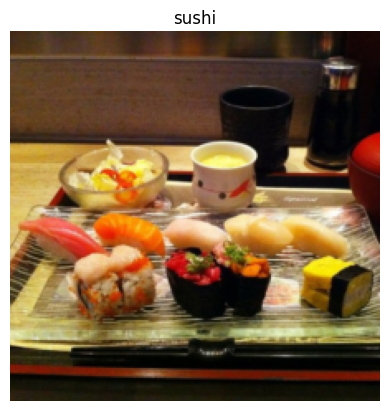

In [6]:
images, labels = next(iter(train_dataloader))
img, label = images[0], labels[0]
plt.imshow(img.permute(1, 2, 0))
plt.title(CLASS_NAMES[label.item()])
plt.axis("off")
plt.show()

# Replicating ViT

## Exploring the Four Equations
The next main part(s) of the ViT paper we're going to look at are the four equations in section 3.1.

**Equations:**
\begin{aligned}
\mathbf{z}_0 & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{p o s}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{p o s} \in \mathbb{R}^{(N+1) \times D} \\
\mathbf{z}_{\ell}^{\prime} & =\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \\
\mathbf{z}_{\ell} & =\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\mathbf{y} & =\operatorname{LN}\left(\mathbf{z}_L^0\right) & &
\end{aligned}

* MSA = multi head self attention
* MLP = multi layer perceptron

#### Equation 1

In pseudocode:

```python
x_input = [class_token, image_patch_1, image_patch_2, ... , image_patch_N] + [class_token_pos, image_patch_pos_1, image_patch_pos_2, ... , image_patch_pos_N]
```

#### Equation 2

In pseudocode:

```python
x_output_msa_block = MultiHeadSelfAttention(LayerNormalization(previous_output)) + previous_output
```

#### Equation 3

In pseudocode:

```python
x_output_mlp_block = MultiLayerPerceptron(LayerNormalization(x_output_msa_block)) + x_output_msa_block
```

#### Equation 4

In pseudocode:

```python
y_output = LinearLayer(LayerNormalization(x_output_mlp_block))
```

## Table 1

<img src="https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-table-1.png?raw=true" width="600"/>


* ViT-Base, ViT-Large, ViT-Huge are all different sizes of models we can replicate. We will start small with Base version to make our experiments quick as possible. However if we will want we will be able to easily change the hyperparameters to use larger versions.

* Layers - the number of transformer encoder layers.
* Hidden size D - the embedding size throughout the architecture.
* MLP size - number if hidden units in **Multi Layer Perceptrons**.
* Heads - number of heads in **MultiheadAttention** layers.
* Params - number of parameters our model will have.

## Equation 1

### Calculating patch embedding input and output shapes by hand

How about we start by calculating these input and output shape values by hand?

To do so, let's create some variables to mimic each of the terms (such as $H$, $W$ etc) above.

We'll use a patch size ($P$) of 16 since it's the best performing version of ViT-Base uses (see column "ViT-B/16" of Table 5 in the ViT paper for more).



In [7]:
height = 224
width = 224
color_channels = 3
patch_size = 16
number_of_patches = int((height * width) / (patch_size ** 2))
print(f"Number of patches = {number_of_patches}")

Number of patches = 196


In [8]:
# input shape
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)
print(f"Input shape = {embedding_layer_input_shape}")
print(f"Output shape = {embedding_layer_output_shape}")

Input shape = (224, 224, 3)
Output shape = (196, 768)


### Turning single image into patches

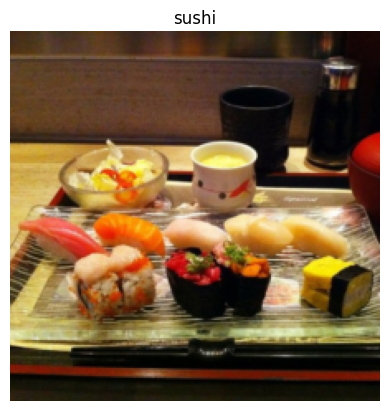

In [9]:
# View a single image
plt.imshow(img.permute(1, 2, 0))
plt.title(CLASS_NAMES[label.item()])
plt.axis("off")
plt.show()

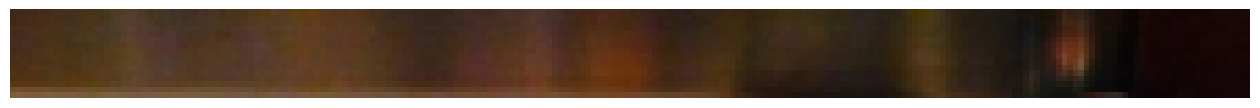

In [10]:
# Get the top row of the image
image_permuted = img.permute(1, 2, 0)

# Index to plot the top row of the pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])
plt.axis("off")
plt.show()

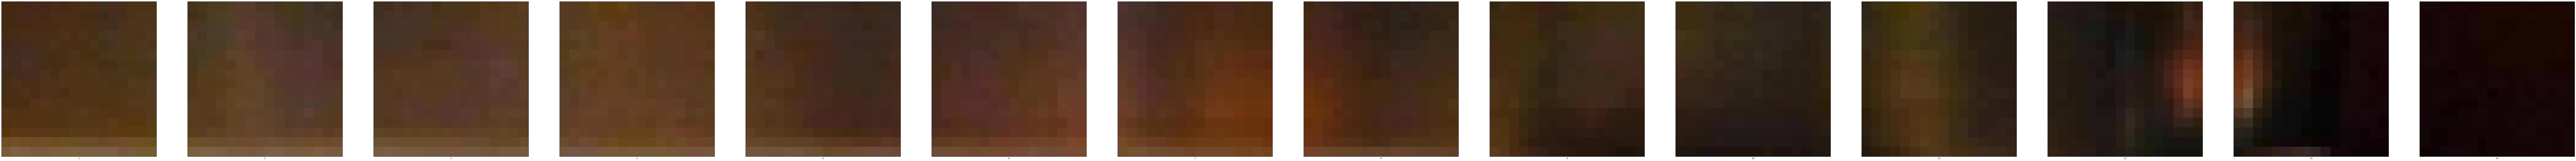

In [11]:
patch_size = 16
num_patches = image_permuted.shape[1] // patch_size

# Set up the figure and subplots
fig, axs = plt.subplots(figsize=(patch_size * num_patches, patch_size),
                        nrows=1,
                        ncols=num_patches,
                        sharex=True,
                        sharey=True)

# Plot each patch in the top row
for index, i in enumerate(range(0, image_permuted.shape[1], patch_size)):
    axs[index].imshow(image_permuted[:patch_size, i:i+patch_size, :])
    axs[index].set_xlabel(index + 1)
    axs[index].set_xticks([])
    axs[index].set_yticks([])

plt.show()

In [12]:
def turn_image_into_patches(img,
                            label,
                            patch_size,
                            img_size=IMG_SIZE):
  image_permuted = img.permute(1, 2, 0)
  assert image_permuted.shape[0] == image_permuted.shape[1] == img_size

  n_rows = image_permuted.shape[0] // patch_size
  n_cols = image_permuted.shape[1] // patch_size

  fig, axs = plt.subplots(nrows=n_rows,
                          ncols=n_cols,
                          sharex=True,
                          sharey=True)
  for i_row in range(n_rows):
    for i_col in range(n_cols):
      patch = image_permuted[i_row*patch_size:(i_row+1)*patch_size,
                             i_col*patch_size:(i_col+1)*patch_size,
                             :]
      axs[i_row, i_col].imshow(patch)
      axs[i_row, i_col].axis("off")
  plt.show()

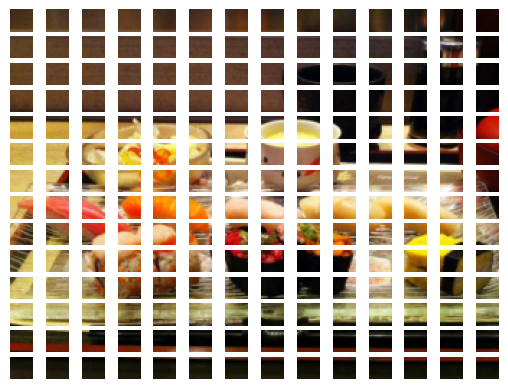

In [13]:
patch_size=16
turn_image_into_patches(img,
                        label,
                        patch_size)

### Turning image patches into embeddings

In [14]:
# Create conv2d layer to turn image into patches
from torch import nn

patch_size = 16
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768, # embedding size from table 1
                   stride=patch_size,
                   kernel_size=patch_size,
                   padding=0)
image_out_of_conv = conv2d(img.unsqueeze(dim=0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Shape of an image passed through our convolutional layer is:

```
(1, 768, 14, 14) -> (number of batches, embedding dimension or number of feature maps, kernel_size, kernel_size)
```

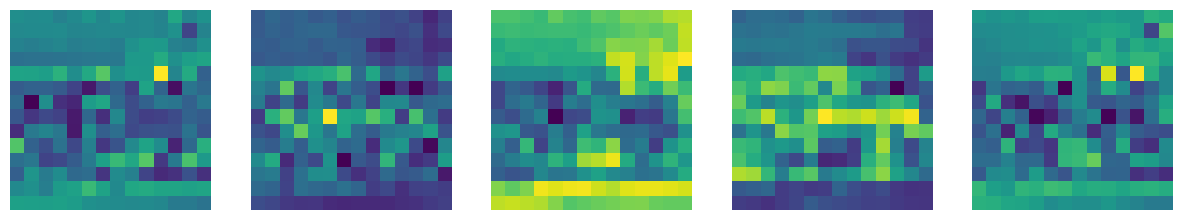

In [15]:
import random
import numpy as np

# Set the figure size
fig, axs = plt.subplots(nrows=1,
                        ncols=5,
                        figsize=(15, 3),
                        sharex=True,
                        sharey=True)

random_indexes = random.sample(range(0, 768), 5)
for i, index in enumerate(random_indexes):
    axs[i].imshow(image_out_of_conv.detach().numpy()[0, index, :, :], cmap='viridis')
    axs[i].axis("off")  # Turn off axes for each subplot

# plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Flattening the patch embeddings with `torch.nn.Flatten` layer

```
We want to go from (1, 768, 14, 14) to (1, 768, 196) since this is the size that vision transformer expect as it's inputs.
```

In [16]:
flatten = nn.Flatten(start_dim=2, end_dim=3)
image_out_of_conv_flattened = flatten(image_out_of_conv)
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"Final shape: {image_out_of_conv_flattened_reshaped.shape}")

Final shape: torch.Size([1, 196, 768])


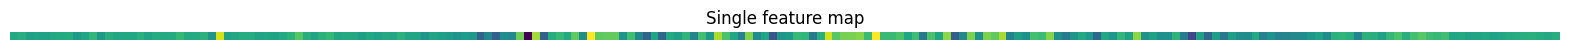

In [17]:
single_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0]
plt.figure(figsize=(20, 20))
plt.imshow(single_feature_map.detach().numpy())
plt.title("Single feature map")
plt.axis("off")
plt.show()

### Turning ViT patch embedding layer into PyTorch layer

In [18]:
class PatchEmbedding(nn.Module):

  def __init__(self,
               in_channels: int,
               out_channels: int,
               patch_size: int,
               demanded_embedding_size: int):
    super().__init__()
    self.demanded_embedding_size = demanded_embedding_size
    self.conv_layer = nn.Conv2d(in_channels=in_channels,
                                out_channels=out_channels,
                                kernel_size=patch_size,
                                stride=patch_size,
                                padding=0)
    self.flatten_layer = nn.Flatten(start_dim=2,
                                    end_dim=3)

  def forward(self, x):
    img_resolution = x.shape[-1]
    assert img_resolution % patch_size == 0, "Input image must be divisible by patch size..."
    # print(x.shape)
    x = self.conv_layer(x)
    # print(x.shape)
    x = self.flatten_layer(x)
    # print(x.shape)
    x = x.permute(0, 2, 1)
    # print(x.shape)
    assert x.shape[-1] == self.demanded_embedding_size
    return x

  def string(self):
    return f"Pass input through conv2d and flatten layer, creating sequence of vectors that we pass into our transformer."

In [19]:
patch_layer = PatchEmbedding(3, 768, patch_size, 768)
print(f"Input image size: {img.shape}")
img_patch = patch_layer(img.unsqueeze(0))
print(f"Input image patchified size: {img_patch.shape}")

Input image size: torch.Size([3, 224, 224])
Input image patchified size: torch.Size([1, 196, 768])


### Creating class token embedding

We want to add extra learnable token to the start of the patch embedding.

In [20]:
# Get the batch size and embedding dimension
batch_size = img_patch.shape[0]
embedding_dimension = img_patch.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [21]:
class_token = nn.Parameter(data=torch.randn(size=(batch_size, 1, embedding_dimension)),
                           requires_grad=True)
print(class_token.shape)

# Adding extra learnable token embeddings
img_patch_with_token = torch.cat((class_token, img_patch), dim=1)
img_patch_with_token.shape

torch.Size([1, 1, 768])


torch.Size([1, 197, 768])

```
[1, 197, 768] -> [batch_size, class_token + number_of_patches, embedding_dimension]
```

### Creating position embeddings

In [22]:
position_embeddings = torch.nn.Parameter(torch.randn(size=(batch_size, number_of_patches+1, 768)),
                                        requires_grad=True)
z0 = img_patch_with_token + position_embeddings
print(f"First output shape: {z0.shape}")

First output shape: torch.Size([1, 197, 768])


### Equation 1 in one cell

In [23]:
patch_size = 16
embedding_size = 768
batched_image = img.unsqueeze(dim=0)

patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       out_channels=embedding_size,
                                       patch_size=patch_size,
                                       demanded_embedding_size=embedding_size)
# Turn image into patches
batched_image_patch = patch_embedding_layer(batched_image)
print(batched_image_patch.shape)

# Add extra learnable token
class_token = torch.randn(size=(1, 1, 768))
batched_image_patch_token = torch.cat((class_token, batched_image_patch), dim=1)
print(batched_image_patch_token.shape)

# Add position embeddings
position_embeddings = torch.nn.Parameter(torch.randn(size=(batch_size, number_of_patches+1, 768)),
                                         requires_grad=True)
z0 = batched_image_patch_token + position_embeddings
print(f"Output shape from equation 1 : {z0.shape}")

torch.Size([1, 196, 768])
torch.Size([1, 197, 768])
Output shape from equation 1 : torch.Size([1, 197, 768])


## Equation 2 -> Multihead self attention

In [24]:
class MultiHeadSelfAttentionBlock(nn.Module):

  def __init__(self,
               embedding_dim = 768,
               num_heads=12,
               attn_dropout=0):
    super().__init__()
    self.normalization_layer = nn.LayerNorm(normalized_shape=embedding_dim)
    self.MSA = nn.MultiheadAttention(embed_dim=embedding_dim,
                                     num_heads=num_heads,
                                     dropout=attn_dropout,
                                     batch_first=True)

  def forward(self, x):
    original_input = x
    # print(x.shape)
    x = self.normalization_layer(x)
    # print(x.shape)
    x, _ = self.MSA(query=x,
                    key=x,
                    value=x,
                    need_weights=False)
    # print(x.shape)
    return x

In [25]:
# Testing our MSA block
MSA_block = MultiHeadSelfAttentionBlock()
z1 = MSA_block(z0)
print(f"z1 shape = {z1.shape}")

z1 shape = torch.Size([1, 197, 768])


In [26]:
z0, z1

(tensor([[[ 2.9984,  0.3247,  1.0071,  ...,  1.1578, -1.3623, -1.9511],
          [ 0.4430, -2.2155, -0.8481,  ...,  0.3383, -1.7670,  0.6901],
          [ 1.1198,  1.5736, -0.7754,  ...,  0.1333, -0.2462, -0.1173],
          ...,
          [ 1.3606,  2.2885,  2.2049,  ...,  0.1883, -0.9271,  0.6347],
          [ 0.5788,  0.0732,  1.0031,  ..., -0.4761,  2.0096,  0.2834],
          [-0.1627,  0.5368,  0.0398,  ...,  1.9544,  0.5840, -0.4903]]],
        grad_fn=<AddBackward0>),
 tensor([[[-0.0891,  0.0536,  0.0541,  ...,  0.0153,  0.0858,  0.0194],
          [-0.0802,  0.0607,  0.0485,  ...,  0.0036,  0.0600,  0.0327],
          [-0.0876,  0.0599,  0.0611,  ...,  0.0228,  0.1211,  0.0243],
          ...,
          [-0.0823,  0.0620,  0.0674,  ...,  0.0023,  0.0986,  0.0012],
          [-0.1055,  0.0465,  0.0646,  ...,  0.0028,  0.1028,  0.0101],
          [-0.0888,  0.0264,  0.0462,  ...,  0.0323,  0.1056,  0.0267]]],
        grad_fn=<TransposeBackward0>))

## Equation 3 -> Multi Layer Perceptron

In [27]:
class MLPBlock(nn.Module):

  def __init__(self,
               embedding_dim=768,
               hidden_units=3072,
               dropout_proba=0.1):
    super().__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
    self.MLP = nn.Sequential(nn.Linear(embedding_dim, hidden_units),
                             nn.GELU(),
                             nn.Dropout(dropout_proba),
                             nn.Linear(hidden_units, embedding_dim),
                             nn.GELU(),
                             nn.Dropout(p=dropout_proba))

  def forward(self, x):
    # print(x.shape)
    x = self.layer_norm(x)
    # print(x.shape)
    x = self.MLP(x)
    # print(x.shape)
    return x

In [28]:
# Testing our MSP block
MSP_block = MLPBlock()
z2 = MSP_block(z1)
print(f"z2 shape = {z2.shape}")

z2 shape = torch.Size([1, 197, 768])


## Building The Transformer Encoder

### Custom

In [29]:
class TransformerEncoderBlock(nn.Module):

  def __init__(self,
               # Hyperparameters from table 1
               hidden_size=768,
               num_heads=12,
               MLP_size=3072,
               dense_dropout_proba=0.1,
               attn_dropout=0):
    super().__init__()
    self.MSA = MultiHeadSelfAttentionBlock(hidden_size,
                                           num_heads,
                                           attn_dropout)
    self.MLP = MLPBlock(hidden_size,
                        MLP_size,
                        dense_dropout_proba)

  def forward(self, x):
    x = self.MSA(x) + x
    x = self.MLP(x) + x
    return x

In [30]:
EncoderBlock = TransformerEncoderBlock()
summary(model=EncoderBlock,
        inputs=(1, 197, 768))

Layer (type:depth-idx)                                  Param #
TransformerEncoderBlock                                 --
├─MultiHeadSelfAttentionBlock: 1-1                      --
│    └─LayerNorm: 2-1                                   1,536
│    └─MultiheadAttention: 2-2                          1,771,776
│    │    └─NonDynamicallyQuantizableLinear: 3-1        590,592
├─MLPBlock: 1-2                                         --
│    └─LayerNorm: 2-3                                   1,536
│    └─Sequential: 2-4                                  --
│    │    └─Linear: 3-2                                 2,362,368
│    │    └─GELU: 3-3                                   --
│    │    └─Dropout: 3-4                                --
│    │    └─Linear: 3-5                                 2,360,064
│    │    └─GELU: 3-6                                   --
│    │    └─Dropout: 3-7                                --
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0

```
[1, 197, 768] -> [batch_size, number_of_patches, embedding_dimension]
```

### With PyTorch build-in layers

PyTorch has build-in layers ready to use: https://pytorch.org/docs/stable/nn.html#transformer-layers.

In [31]:
PyTorchEncoderBlock = nn.TransformerEncoderLayer(d_model=768,
                                                 nhead=12,
                                                 dim_feedforward=3072,
                                                 dropout=0.1,
                                                 activation=nn.GELU())
summary(model=PyTorchEncoderBlock,
        inputs=(1, 197, 768))

Layer (type:depth-idx)                             Param #
TransformerEncoderLayer                            --
├─MultiheadAttention: 1-1                          1,771,776
│    └─NonDynamicallyQuantizableLinear: 2-1        590,592
├─Linear: 1-2                                      2,362,368
├─Dropout: 1-3                                     --
├─Linear: 1-4                                      2,360,064
├─LayerNorm: 1-5                                   1,536
├─LayerNorm: 1-6                                   1,536
├─Dropout: 1-7                                     --
├─Dropout: 1-8                                     --
├─GELU: 1-9                                        --
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0

## Putting it all together

In [32]:
class ViT(nn.Module):

  def __init__(self,
               num_classes,
               img_size=224,
               patch_size=16,
               Layers=12,
               hidden_size=768,
               MLP_size=3072,
               heads=12,
               mlp_dropout=0.1,
               attn_dropout=0.0):
    super().__init__()
    assert img_size % patch_size == 0, f"Image size {img_size} has to be divisible by {patch_size}..."
    number_of_patches = int((img_size * img_size) / (patch_size**2))

    # Create layer to patch our images
    self.patch_embedding_layer = PatchEmbedding(in_channels=3,
                                                out_channels=hidden_size,
                                                patch_size=patch_size,
                                                demanded_embedding_size=hidden_size)
    # Create class embedding
    self.class_token = nn.Parameter(torch.randn(size=(1, 1, hidden_size)))

    # Create position embeddings
    self.position_embedding = torch.nn.Parameter(torch.randn(size=(1, number_of_patches+1, hidden_size)),
                                                 requires_grad=True)

    # Create stack of encoders
    self.transformer_encoder = []
    for _ in range(Layers):
      self.transformer_encoder.append(TransformerEncoderBlock(hidden_size,
                                                              heads,
                                                              MLP_size,
                                                              mlp_dropout,
                                                              attn_dropout))
    self.transformer_encoder = nn.Sequential(*self.transformer_encoder)

    # Create classifier layer
    self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape=hidden_size),
                                    nn.Linear(hidden_size, num_classes))


  def forward(self, x):

    # Get batch size
    batch_size = x.shape[0]
    # Create class token embedding and expand it to match the batch size (equation 1)
    class_token = self.class_token.expand(batch_size, -1, -1) # "-1" means to infer the dimension

    x = self.patch_embedding_layer(x)
    x = torch.cat((class_token, x), dim=1)
    x = x + self.position_embedding
    for encoder in self.transformer_encoder:
      x = encoder(x)
    return self.classifier(x[:, 0])

In [33]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [34]:
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)
vit = ViT(num_classes=3)
vit(random_image_tensor)

tensor([[-0.2808,  1.4599, -0.7919]], grad_fn=<AddmmBackward0>)

In [35]:
from torchinfo import summary
# Print a summary of our custom ViT model using torchinfo
summary(model=ViT(num_classes=3),
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                               [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding_layer)                [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (conv_layer)                              [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten_layer)                          [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Sequential (transformer_encoder)                      --                   --                   --                   True
│    └─TransformerEncoderBlock (0)                      [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─MultiHeadSelfAttentionBlock (MSA)           [32, 197, 768]       [32, 197, 768]       2,363,904            True
│    

## Training ViT

In [36]:
from going_modular.going_modular import engine

ViT_model = ViT(num_classes=3)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=ViT_model.parameters(),
                             lr=1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

EPOCHS = 20
vit_history = engine.train(ViT_model,
                           train_dataloader,
                           test_dataloader,
                           optimizer,
                           loss_fn,
                           EPOCHS,
                           device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9882 | train_acc: 0.3229 | test_loss: 1.5804 | test_acc: 0.2875
Epoch: 2 | train_loss: 1.3354 | train_acc: 0.2938 | test_loss: 1.2277 | test_acc: 0.3500
Epoch: 3 | train_loss: 1.1958 | train_acc: 0.2875 | test_loss: 1.1223 | test_acc: 0.2875
Epoch: 4 | train_loss: 1.1329 | train_acc: 0.2750 | test_loss: 1.1114 | test_acc: 0.3625
Epoch: 5 | train_loss: 1.1246 | train_acc: 0.3187 | test_loss: 1.1864 | test_acc: 0.2875
Epoch: 6 | train_loss: 1.1281 | train_acc: 0.3146 | test_loss: 1.1380 | test_acc: 0.2875
Epoch: 7 | train_loss: 1.1208 | train_acc: 0.3375 | test_loss: 1.1059 | test_acc: 0.2875
Epoch: 8 | train_loss: 1.0982 | train_acc: 0.3750 | test_loss: 1.1201 | test_acc: 0.3500
Epoch: 9 | train_loss: 1.1240 | train_acc: 0.3875 | test_loss: 1.1993 | test_acc: 0.2875
Epoch: 10 | train_loss: 1.1532 | train_acc: 0.3146 | test_loss: 1.1010 | test_acc: 0.2875
Epoch: 11 | train_loss: 1.1042 | train_acc: 0.3417 | test_loss: 1.1866 | test_acc: 0.2875
Epoch: 12 | train_l

In [37]:
import pandas as pd

df = pd.DataFrame(vit_history)

# Save as csv
df.to_csv("/content/model_results.csv", index=False)
# Save DataFrame as a JSON file
df.to_json("/content/model_results.json", orient='records', lines=True)

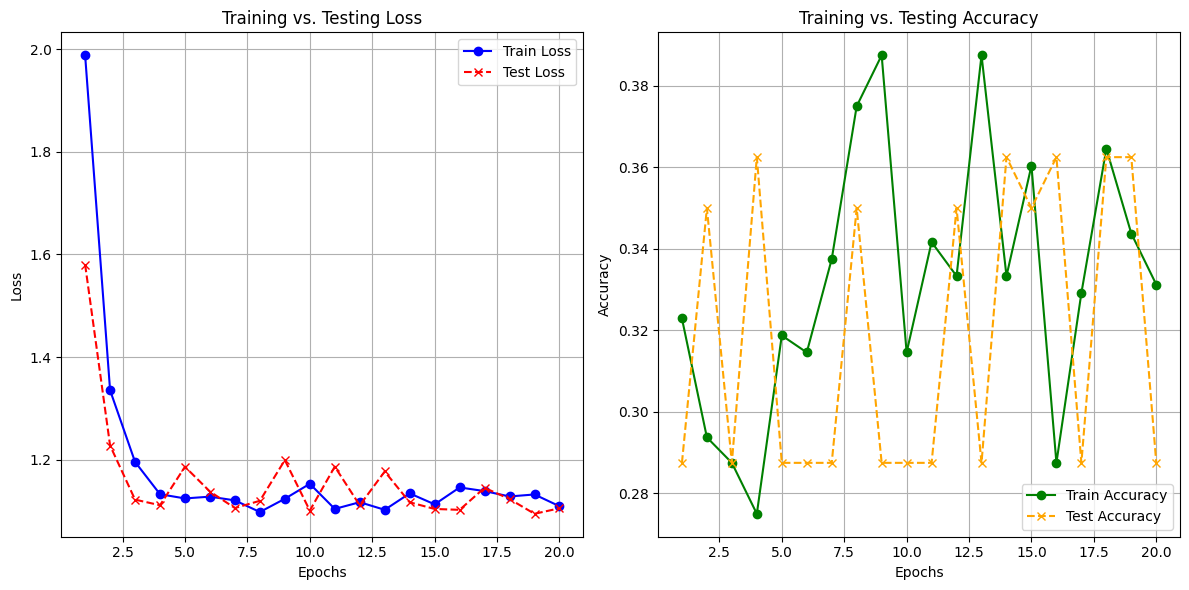

In [38]:
def plot_training_results(dictionary):

  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=True)

  # Define the epochs
  epochs = np.arange(EPOCHS) + 1

  # Plotting Losses
  axs[0].plot(epochs, dictionary["train_loss"], label="Train Loss", color='blue', linestyle='-', marker='o')
  axs[0].plot(epochs, dictionary["test_loss"], label="Test Loss", color='red', linestyle='--', marker='x')
  axs[0].set_title("Training vs. Testing Loss")
  axs[0].set_xlabel("Epochs")
  axs[0].set_ylabel("Loss")
  axs[0].grid(True)
  axs[0].legend(loc="upper right")

  # Plotting Accuracies
  axs[1].plot(epochs, dictionary["train_acc"], label="Train Accuracy", color='green', linestyle='-', marker='o')
  axs[1].plot(epochs, dictionary["test_acc"], label="Test Accuracy", color='orange', linestyle='--', marker='x')
  axs[1].set_title("Training vs. Testing Accuracy")
  axs[1].set_xlabel("Epochs")
  axs[1].set_ylabel("Accuracy")
  axs[1].grid(True)
  axs[1].legend(loc="lower right")

  # Adjust the layout and show the plot
  plt.tight_layout()
  plt.show()

plot_training_results(vit_history)

## Use pretrained ViT from `torchvision.models`

In [39]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

weights = ViT_B_16_Weights.DEFAULT

In [40]:
pretrained_vit_model = vit_b_16(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 58.5MB/s]


In [41]:
summary(model=pretrained_vit_model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1000]           768                  True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              True
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 197, 76

In [42]:
for param in pretrained_vit_model.parameters():
  param.requires_grad=False

pretrained_vit_model.heads = nn.Sequential(nn.Linear(in_features=768,
                                                     out_features=3,
                                                     bias=True)).to(device)

# # Do a summary *after* freezing the features and changing the output classifier layer
summary(pretrained_vit_model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [43]:
data_transforms_vit = weights.transforms()
print(f"Manual transforms = {data_transforms_vit}")

# Create train and test dataloaders
train_dataloader_vit, test_dataloader_vit, CLASS_NAMES = create_dataloaders(train_dir,
                                                                    test_dir,
                                                                    data_transforms_vit,
                                                                    BATCH_SIZE)
len(train_dataloader_vit), len(test_dataloader_vit), CLASS_NAMES

Manual transforms = ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


(15, 5, ['pizza', 'steak', 'sushi'])

In [45]:
pretrained_loss_fn = nn.CrossEntropyLoss()
pretrained_optimizer = torch.optim.Adam(params=pretrained_vit_model.parameters(),
                             lr=1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

EPOCHS = 10
pretrained_vit_history = engine.train(pretrained_vit_model,
                                      train_dataloader_vit,
                                      test_dataloader_vit,
                                      pretrained_optimizer,
                                      pretrained_loss_fn,
                                      EPOCHS,
                                      device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1527 | train_acc: 0.9604 | test_loss: 0.0908 | test_acc: 0.9784
Epoch: 2 | train_loss: 0.1048 | train_acc: 0.9750 | test_loss: 0.0756 | test_acc: 0.9875
Epoch: 3 | train_loss: 0.0953 | train_acc: 0.9812 | test_loss: 0.0684 | test_acc: 1.0000
Epoch: 4 | train_loss: 0.0711 | train_acc: 0.9854 | test_loss: 0.0626 | test_acc: 0.9938
Epoch: 5 | train_loss: 0.0641 | train_acc: 0.9896 | test_loss: 0.0650 | test_acc: 0.9875
Epoch: 6 | train_loss: 0.0619 | train_acc: 0.9938 | test_loss: 0.0666 | test_acc: 0.9938
Epoch: 7 | train_loss: 0.0589 | train_acc: 0.9958 | test_loss: 0.0649 | test_acc: 0.9938
Epoch: 8 | train_loss: 0.0594 | train_acc: 0.9958 | test_loss: 0.0628 | test_acc: 0.9875
Epoch: 9 | train_loss: 0.0539 | train_acc: 0.9938 | test_loss: 0.0615 | test_acc: 0.9938
Epoch: 10 | train_loss: 0.0728 | train_acc: 0.9938 | test_loss: 0.0631 | test_acc: 0.9875


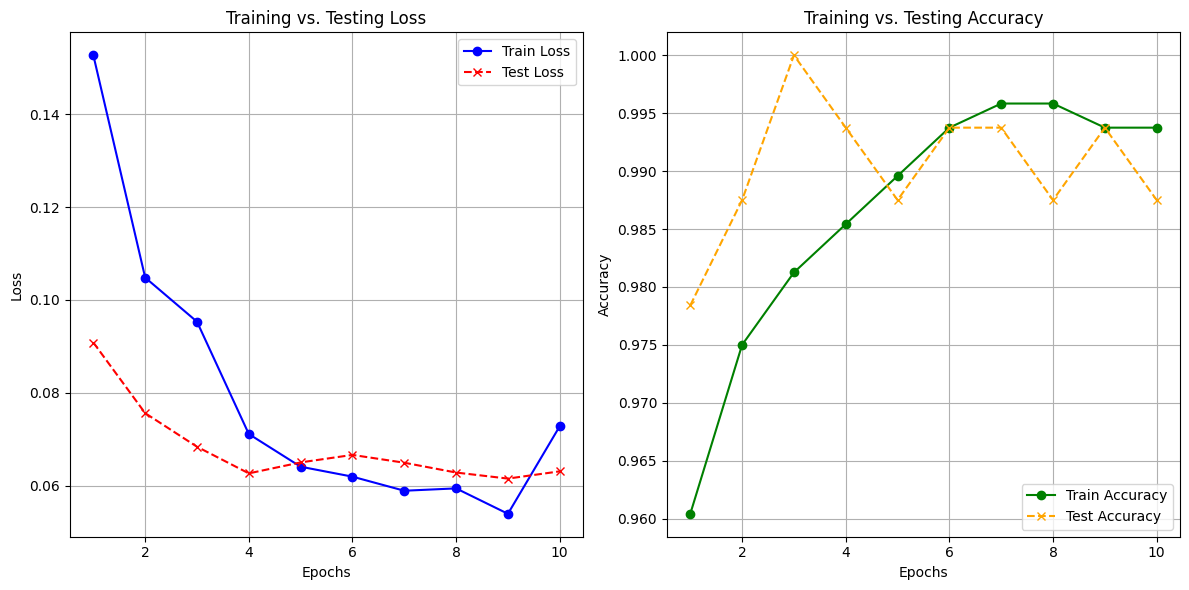

In [46]:
plot_training_results(pretrained_vit_history)

## Save model

In [47]:
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit_model,
                 target_dir="models",
                 model_name="pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [51]:
from pathlib import Path

# Let's check model size
size = Path("/content/models/pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size
print(f"Model size in MB = {size / (1024 * 1024):.2f}")

Model size in MB = 327.37


## Make prediction on custom image

In [52]:
import requests
from pathlib import Path

if Path("steak.jpeg").is_file():
  print(f"steak image is arleady downloaded...")
else:
  url = "https://raw.githubusercontent.com/Mateusz-best-creator/Learning_PyTorch/main/going_modular/scripts/steak.jpeg"
  request = requests.get(url)
  print(f"Downloading data from {url}...")
  with open("steak.jpeg", "wb") as f:
    f.write(request.content)

In [54]:
CLASS_NAMES

['pizza', 'steak', 'sushi']

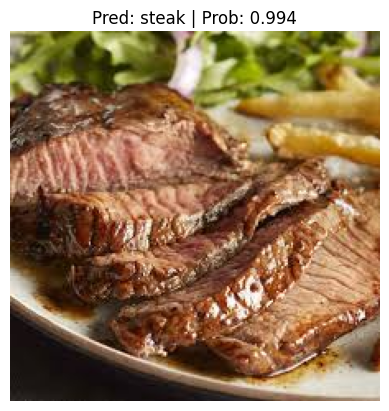

In [55]:
from going_modular.going_modular import predictions

predictions.pred_and_plot_image(pretrained_vit_model,
                                CLASS_NAMES,
                                "steak.jpeg",
                                image_size=(224,224),
                                transform=data_transforms_vit,
                                device=device)

YEAH BUDDY!!!